# Tree Based Models
This notebook include models on:    
* Decision trees with DecisionTreeRegressor
* Random Forest with RandomForestRegressor
* XG Boosting with xgb

## Import Libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import arange
import seaborn as sns
import plotly.express as px
import time

# SK-learn libraries for processing.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config

# SK-learn libraries for learning.
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# SK-learn libraries for evaluation.
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

pd.options.display.max_rows = 4000

## Import Data
Data imported is the final NBA data that include past NBA games since 2005 joined with each team's player clusters

In [2]:
nba_data_final = pd.read_csv('nba_final_data.csv')

Check the outcome variable on margin of victory

In [3]:
nba_data_final['PLUS_MINUS_HOME'].describe()

count    16635.000000
mean         2.897205
std         13.312930
min        -56.000000
25%         -7.000000
50%          4.000000
75%         11.000000
max         61.000000
Name: PLUS_MINUS_HOME, dtype: float64

In [4]:
nba_data_final.head()

,GAME_ID,TEAM_ID_HOME,TEAM_ID_AWAY,GAME_DATE,SEASON,PLUS_MINUS_HOME,MIN_HOME,FGA_HOME,FG_PCT_HOME,FG3A_HOME,...,cluster_2a,cluster_3a,cluster_4a,cluster_5a,cluster_6a,cluster_7a,cluster_8a,cluster_9a,cluster_10a,cluster_11a
0,20400946,1610612737,1610612764,2005-03-16,2004,-29,240.0,82.000000,0.439000,14.000000,...,2,0,1,2,0,0,0,3,0,2
1,20500068,1610612737,1610612746,2005-11-10,2005,-7,240.0,78.500000,0.466000,14.500000,...,1,0,0,1,1,0,1,6,0,1
2,20500082,1610612737,1610612763,2005-11-12,2005,-1,240.0,82.666667,0.446333,12.666667,...,1,0,0,2,1,0,0,5,0,0
3,20500156,1610612737,1610612738,2005-11-23,2005,3,240.0,82.750000,0.434250,12.500000,...,2,0,0,1,0,0,1,6,1,1
4,20500190,1610612737,1610612757,2005-11-27,2005,-2,240.0,80.600000,0.458600,11.600000,...,0,0,2,2,2,0,1,5,0,0


In [5]:
nba_data_final.shape

(16635, 71)

**Drop columns that are not used in the model**

In [6]:
game_data = nba_data_final.drop(['GAME_ID','TEAM_ID_HOME','TEAM_ID_AWAY','GAME_DATE','SEASON'
                                          # , 'MIN_HOME','FGA_HOME','FGA_AWAY','STL_AWAY','STL_HOME','PF_AWAY','PF_HOME',
                                          #  'FG_PCT_AWAY','FG_PCT_HOME','FG3A_AWAY','FG3A_HOME'                                            
                                           ], axis = 1)


In [7]:
game_data.head()

,PLUS_MINUS_HOME,MIN_HOME,FGA_HOME,FG_PCT_HOME,FG3A_HOME,FG3_PCT_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,...,cluster_2a,cluster_3a,cluster_4a,cluster_5a,cluster_6a,cluster_7a,cluster_8a,cluster_9a,cluster_10a,cluster_11a
0,-29,240.0,82.000000,0.439000,14.000000,0.571000,17.000000,0.765000,15.000000,25.0,...,2,0,1,2,0,0,0,3,0,2
1,-7,240.0,78.500000,0.466000,14.500000,0.419000,21.500000,0.748000,12.000000,28.0,...,1,0,0,1,1,0,1,6,0,1
2,-1,240.0,82.666667,0.446333,12.666667,0.316333,23.333333,0.745667,13.666667,27.0,...,1,0,0,2,1,0,0,5,0,0
3,3,240.0,82.750000,0.434250,12.500000,0.320500,22.250000,0.743500,14.250000,27.5,...,2,0,0,1,0,0,1,6,1,1
4,-2,240.0,80.600000,0.458600,11.600000,0.406400,25.400000,0.773800,14.200000,26.8,...,0,0,2,2,2,0,1,5,0,0


## Define features and out comes and split data

Define features (game_data_x) and outcome (game_data_y)

In [8]:
game_data_x = game_data.drop(['PLUS_MINUS_HOME','WL_Home_modified'], axis = 1)
game_data_y = game_data['PLUS_MINUS_HOME']

Split to training and testing at 80/20 proportion

In [9]:
X_train, X_test, y_train, y_test = train_test_split(game_data_x, 
                                                    game_data_y, 
                                                    test_size=0.2, random_state=42)

Created normalized and standardized training and testing

In [10]:
X_train_normalized = preprocessing.normalize(X_train)
X_train_standardized = standardized_X = preprocessing.scale(X_train)
X_test_normalized = preprocessing.normalize(X_test)
X_test_standardized = standardized_X = preprocessing.scale(X_test)

## Define evaluation method
Calculate evaluation metrics based on the predict outcome and actual outcome for:    
* Accuracy
* F1 Score
* R square
* RMSE

In [11]:
def model_evaluation(y_pred, y_actual):
    """
    returns evaluation metrics for the model:
    Accuracy, F1 Score, R Squre, RMSE
    """
    acc = 0
    f1score = 0
    rmse = 0
    r_sqaure = 0
    
    if len(y_pred) != len(y_actual):
        print('predicted and actual length not equal')
        
    else:
        len_y = len(y_pred)
        
        y_pred_bool =  y_pred >= 0
        y_actual_bool =  y_actual >= 0
        f1score = f1_score(y_actual_bool, y_pred_bool, average='binary')
        acc = accuracy_score(y_actual_bool, y_pred_bool)
        
        rmse = np.sqrt(mse(y_actual, y_pred))
        r_sqaure = r2_score(y_actual, y_pred)
        
    df_evaluation = pd.DataFrame({'Accuracy': pd.Series(acc),
                                 'F1 Score': pd.Series(f1score),
                                 'R Square': pd.Series(r_sqaure),
                                 'RMSE': pd.Series(rmse)})
    return(df_evaluation)
        
    

## Decision Tree

Decision Tree Regressor on training and testing without normalization nor standardization

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square     RMSE
0  0.632627  0.736029  0.093848  12.6463


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.625789  0.732546  0.063731  12.982533




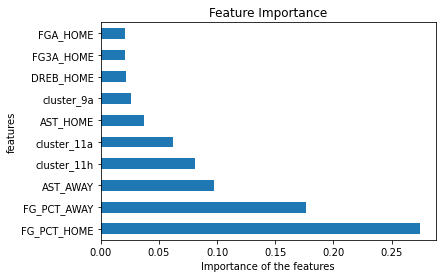

In [34]:
regressor = DecisionTreeRegressor(random_state = 0,
                                  criterion='mse', max_depth=50,
                                  max_leaf_nodes=30,
                                  min_samples_leaf=100, min_samples_split=100) 
regressor.fit(X_train, y_train)

y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_train, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_test, y_test))
print('\n')

#plt.scatter(y_train,y_pred_train)
#plt.scatter(y_test,y_pred_test)

feat_importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

Decision Tree Regressor on normalized training and testing

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.637211  0.740067  0.099394  12.607536


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.628795  0.737066  0.054845  13.043994




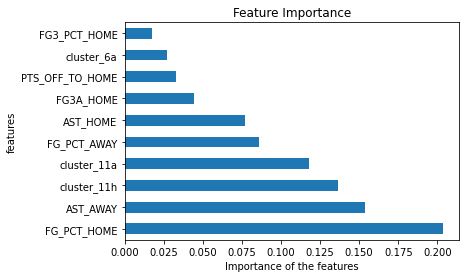

In [35]:
regressor_normalized = DecisionTreeRegressor(random_state = 0,
                                             criterion='mse', max_depth=50,
                                             max_leaf_nodes=30,
                                             min_samples_leaf=100, min_samples_split=100) 
regressor_normalized.fit(X_train_normalized, y_train)

y_pred_train_normalized = regressor_normalized.predict(X_train_normalized)
y_pred_test_normalized = regressor_normalized.predict(X_test_normalized)

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_train_normalized, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_test_normalized, y_test))
print('\n')
#plt.scatter(y_train,y_pred_train)
#plt.scatter(y_test,y_pred_test)

feat_importances_normalized = pd.Series(regressor_normalized.feature_importances_, index=X_train.columns)
feat_importances_normalized.nlargest(10).plot(kind='barh')

plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

Decision Tree Regressor on standardized training and testing

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square     RMSE
0  0.632627  0.736029  0.093848  12.6463


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square      RMSE
0  0.626991  0.733976  0.064938  12.97416




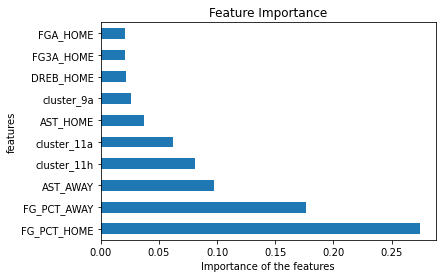

In [42]:
regressor_standardized = DecisionTreeRegressor(random_state = 0,
                                               criterion='mse', max_depth=50,
                                               max_leaf_nodes=30,
                                               min_samples_leaf=100, min_samples_split=100) 
regressor_standardized.fit(X_train_standardized, y_train)

y_pred_train_standardized = regressor_standardized.predict(X_train_standardized)
y_pred_test_standardized = regressor_standardized.predict(X_test_standardized)

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_train_standardized, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_test_standardized, y_test))
print('\n')

#plt.scatter(y_train,y_pred_train)
#plt.scatter(y_test,y_pred_test)

feat_importances_normalized = pd.Series(regressor_standardized.feature_importances_, index=X_train.columns)
feat_importances_normalized.nlargest(10).plot(kind='barh')

plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

**Since standardized performed better than normalized, the models below are based on standarized training and testing datasets**

### Parameter tunning for decision tree regression

Define the parameters for tunning

In [22]:
# Other paramter with wider range are tunned and the range was narrowed to get to the one below that gives the best result
parameters_decision_tree={"splitter":["best","random"],
                          "max_depth" : [5,10,20,30],
                          "min_samples_leaf":[10,20,30,40],
                          "min_weight_fraction_leaf":[0.01,0.1],
                          "max_features":["auto","log2","sqrt",None],
                          "max_leaf_nodes":[None,40, 80, 120] }

Tune model

In [57]:
reg_decision_model_stand=DecisionTreeRegressor()

tuning_model_decision_tree_stand=GridSearchCV(reg_decision_model_stand,
                                              param_grid=parameters_decision_tree,
                                              scoring='neg_mean_squared_error',
                                              cv=3,
                                              verbose=3)

start_time_train = time.time()

tuned_mode_stand = tuning_model_decision_tree_stand.fit(X_train_standardized,y_train)

end_time_train = time.time()
time_used = end_time_train - start_time_train
print("Time used to tune  the model:"  + str(time_used))

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-165.533, total=   0.2s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-171.245, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-168.943, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-163.251, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.997, total= 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-165.569, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-166.208, total=   0.0s
[CV]

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-165.533, total=   0.2s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-171.245, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-168.943, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-164.091, total=   0.

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-165.533, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-171.245, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-168.943, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-165.712, total=   0.0s
[CV] max_de

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-165.569, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-166.588, total=   0.0s
[CV] max_depth=5, 

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-165.533, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-171.245, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-168.943, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-166.163, total=   0.0s
[CV]

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-167.648, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-173.466, total=   0.0s
[CV] ma

[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-169.927, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-175.630, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, ma

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-176.180, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-167.449, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-172.446, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-174.393, total=   0.0s
[CV] max_depth=5, m

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-177.469, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-168.024, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-175.901, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.061, total=   0.0s
[CV] max_depth

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.971, total=   0.1s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-171.732, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-178.511, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-176.106, total=   0.0s
[CV] max_d

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-173.454, total=   0.1s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-168.697, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-177.008, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-174.702, total=   0

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-167.726, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-175.921, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-173.993, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-167.595, total= 

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.853, total=   0.1s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-168.376, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-174.007, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-174.947, total=   0.0s
[CV

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-175.972, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-170.118, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-174.389, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-171.977, total=   0.0s
[CV] max_depth

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-173.232, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-168.850, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-178.240, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-175.722, total=   0.0s
[CV

[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.324, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-168.799, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-176.840, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_featur

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-170.544, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-177.908, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-177.337, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-165.533, total=   0.1s
[

[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-167.156, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-172.126, total=   0.0s


[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-171.245, total=   0.2s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-168.943, total=   0.2s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-164.782, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.983, total=   0.1s
[CV] ma

[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-166.194, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-175.331, total=   0.0s
[CV] max_depth

[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-171.245, total=   0.3s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-168.943, total=   0.3s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-163.152, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-172.853, total=   0.0s
[CV] ma

[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-165.347, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-174.135, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-172.608, total=   0.0s
[CV

[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-168.943, total=   0.2s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-164.171, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-173.999, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-166.897, total=   0

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-168.437, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-175.168, total= 

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-164.519, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-170.964, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-170.853, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-165.486, total=   0.0s
[CV]

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-165.569, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-167.106, total=   0.0s
[CV] max_de

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-168.022, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.945, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.921, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-162.126, total=   0.0s
[CV]

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-167.638, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-176.534, total=   0.0s
[CV] ma

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.921, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-164.521, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-172.839, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-168.756, tot

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-173.392, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.182, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total= 

[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-168.771, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.653, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-173.390, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_featur

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-179.404, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-175.779, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-168.285, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-172.527, total=   0.0s
[CV] m

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-173.389, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-173.859, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-171.944, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-177.956, total=   0.0s
[CV] ma

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-172.970, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-169.273, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-179.623, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-177.337, total=   0

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-179.386, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-174.510, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-169.398, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.325, total=  

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-173.498, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-171.432, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-178.950, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-176.186, tot

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-174.003, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-170.553, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-177.534, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-177.024, total=   0.0s
[CV

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-172.438, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.531, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-175.857, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-173.163, total=   0.0s
[CV

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-174.540, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-171.976, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-176.285, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-175.290, total=   0.0s
[CV

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-170.866, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-170.288, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-176.885, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-175.937, total=   0

[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.945, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.921, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-162.709, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.117, 

[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-165.569, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-166.725, total=   0.

[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-164.519, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-170.965, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-170.853, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-162.805, total=   0.0s
[CV]

[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-165.737, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-174.629, total=   0.0s
[CV] ma

[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-172.943, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-174.921, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-164.732, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-171.140, total=   0.0s


[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-167.231, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-172.574, total=   0.0s


[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.3s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-164.960, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.424, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-169.6

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-168.049, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-176.394, total= 

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-170.853, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-163.545, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-172.088, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-167.048, total=   0

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-171.736, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-168.256, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-172.945, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] ma

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-165.569, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-165.474, total=   0.0s
[CV] max_de

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-168.256, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.943, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-164.504, total=   0.

[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-165.569, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-169.371, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-175.183, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-171.859, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-167.134, 

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-175.371, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-173.876, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-167.195, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-173.189, total=   0.0s
[CV] m

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-166.381, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-175.001, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-173.879, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.961, total=   0.0s
[CV] max_de

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-173.334, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-167.363, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-173.079, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-173.800, total=   0

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-175.601, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-171.060, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-179.700, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-175.125, total=   0

[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-173.412, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.187, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-179.850, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-176.667, tot

[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-180.017, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-175.622, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-168.658, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-175.552, total=

[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-166.956, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-173.786, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-171.269, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-167.676, total=   0.0s


[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-167.802, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-177.119, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-173.732, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-166.774, total=   0.0s


[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-168.553, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-175.229, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-168.172, total= 

[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-168.136, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-174.036, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-174.477, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, m

[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-168.256, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-172.943, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-163.778, tota

[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-166.491, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.342, total=   0.0s
[CV] ma

[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-170.853, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-163.938, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-170.642, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-168.304, total=   0

[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-167.066, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-174.694, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-171.861, total=   0.0s
[CV

[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-166.264, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-170.310, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-170.361, tot

[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-166.791, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-175.815, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-172.945, total=   0

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.943, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-163.248, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-168.568, 

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-166.186, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-172.702, total= 

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-170.853, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-162.441, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-170.887, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-169.598, total=   0

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-168.256, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.943, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-164.338, total=   0.1s
[CV]

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-167.216, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-176.325, total=   0.0s
[CV] ma

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-172.943, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-163.636, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-169.431, total= 

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-170.960, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-170.042, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-176.029, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-173.8

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-174.354, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-173.859, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-167.744, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-173.116, total=   0.0s
[CV] m

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-175.413, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-166.634, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-172.407, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-171.556, total=   0.0s
[CV] ma

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-169.074, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-176.105, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-176.896, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-168.770, total=   0.0s


[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-170.519, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-175.019, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-169.240, total= 

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-168.498, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-174.163, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.893, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-166.761, 

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-173.099, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-167.835, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-179.477, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-176.633, tot

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-172.526, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-169.517, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-179.734, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-176.914, total=   0.0s
[CV

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-176.448, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-172.811, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-168.445, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] ma

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.954, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-170.130, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-177.917, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-177.086, total=   0.0s
[CV

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-172.584, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-175.451, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-170.324, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-178.350, total=   0.0s


[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.943, total=   0.2s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.602, total=   0.2s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-162.164, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-172.621, 

[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-166.961, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-175.280, total= 

[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-170.853, total=   0.2s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-164.211, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-168.710, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-168.648, total=   0

[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-166.149, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-173.682, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-173.007, total=   0.0s
[CV

[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.867, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.527, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-167.294, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=

[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  2.7min finished


Get the best parameters

In [58]:
tuned_mode_stand.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 80,
 'min_samples_leaf': 20,
 'min_weight_fraction_leaf': 0.01,
 'splitter': 'random'}

In [59]:
tuned_mode_stand.best_estimator_

DecisionTreeRegressor(max_depth=10, max_features='auto', max_leaf_nodes=80,
                      min_samples_leaf=20, min_weight_fraction_leaf=0.01,
                      splitter='random')

Run the DecisionTreeRegressor with the best parameters based on parameter tunning

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.631425  0.729379  0.090377  12.670495


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.634806  0.736271  0.061603  12.997274




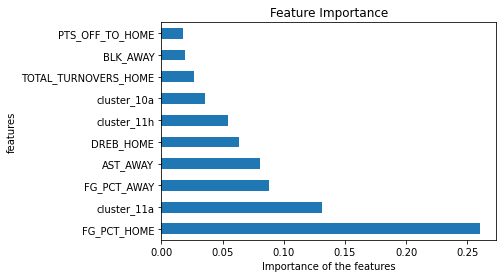

In [60]:
regressor_tuned = DecisionTreeRegressor(max_depth=10, max_features='auto', max_leaf_nodes=80,
                                        min_samples_leaf=20, min_weight_fraction_leaf=0.01,
                                        splitter='random', criterion='mse') 
regressor_tuned.fit(X_train_standardized, y_train)

y_pred_train_tuned = regressor_tuned.predict(X_train_standardized)
y_pred_test_tuned = regressor_tuned.predict(X_test_standardized)

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_train_tuned, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_test_tuned, y_test))
print('\n')

#plt.scatter(y_train,y_pred_train_tuned)
#plt.scatter(y_test,y_pred_test_tuned)

feat_importances_tuned = pd.Series(regressor_tuned.feature_importances_, index=X_train.columns)
feat_importances_tuned.nlargest(10).plot(kind='barh')

plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

**The tuned decision tree regressor was not performing better, but the training dataset use less overfitting.**

## Random Forest 

**Train with a basic random forest regressor**

In [61]:
set_config(print_changed_only=False) 
 
rfr_standardized = RandomForestRegressor()
rfr_standardized.fit(X_train_standardized, y_train)

y_pred_rfr_train_standardized = rfr_standardized.predict(X_train_standardized)

y_pred_rfr_test_standardized = rfr_standardized.predict(X_test_standardized)

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_rfr_train_standardized, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_rfr_test_standardized, y_test))
print('\n')

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square      RMSE
0  0.948452  0.957312  0.870941  4.772615


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.633904  0.722045  0.078068  12.882742




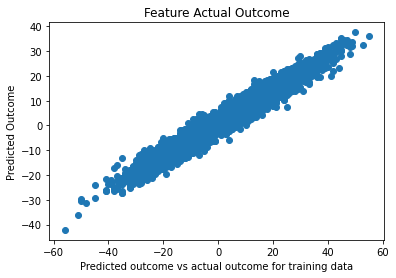

In [64]:
plt.xlabel('Predicted outcome vs actual outcome for training data')
plt.ylabel('Predicted Outcome')
plt.title('Feature Actual Outcome')
plt.scatter(y_train,y_pred_rfr_train_standardized)

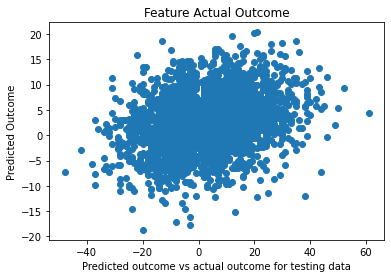

In [65]:
plt.xlabel('Predicted outcome vs actual outcome for testing data')
plt.ylabel('Predicted Outcome')
plt.title('Feature Actual Outcome')
plt.scatter(y_test,y_pred_rfr_test_standardized)

### Parameter tunning for random forest regressor

In [29]:
# Other paramter with wider range are tunned and the range was narrowed to get to the one below that gives the best result

param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 72, 74],
    'max_features': [20, 30, 40],
    'min_samples_leaf': [10, 14, 18],
    'min_samples_split': [13, 14, 15],
    'n_estimators': [2200, 2400, 2600]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [30]:
rf_tuned = grid_search.fit(X_train_standardized, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 111.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 293.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 533.8min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 635.9min finished


In [31]:
rf_tuned.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 20,
 'min_samples_leaf': 18,
 'min_samples_split': 14,
 'n_estimators': 2400}

In [32]:
best_grid = rf_tuned.best_estimator_
best_grid

RandomForestRegressor(max_depth=70, max_features=20, min_samples_leaf=18,
                      min_samples_split=14, n_estimators=2400)

Run the DecisionTreeRegressor with the best parameters based on parameter tunning

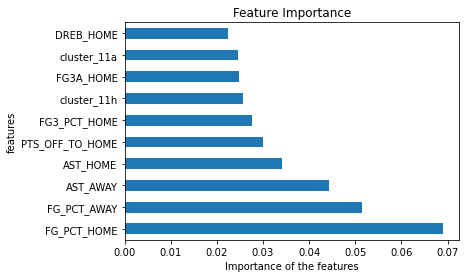

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.752931  0.813033   0.35238  10.691114


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.645927  0.741213  0.109036  12.664531




In [33]:
rf_tuned = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=18,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=2400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 
rf_tuned.fit(X_train_standardized, y_train)

y_pred_rf_train_tuned = rf_tuned.predict(X_train_standardized)
y_pred_rf_test_tuned = rf_tuned.predict(X_test_standardized)

feat_importances_rf_tuned = pd.Series(rf_tuned.feature_importances_, index=X_train.columns)
feat_importances_rf_tuned.nlargest(10).plot(kind='barh')

plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_rf_train_tuned, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_rf_test_tuned, y_test))
print('\n')

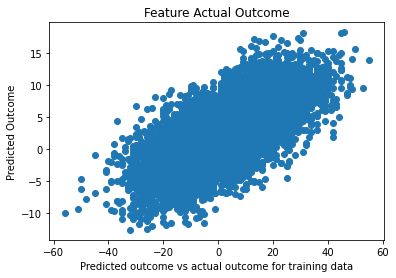

In [36]:
plt.xlabel('Predicted outcome vs actual outcome for training data')
plt.ylabel('Predicted Outcome')
plt.title('Feature Actual Outcome')
plt.scatter(y_train,y_pred_rf_train_tuned)

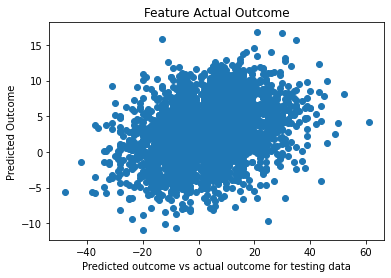

In [37]:
plt.xlabel('Predicted outcome vs actual outcome for testing data')
plt.ylabel('Predicted Outcome')
plt.title('Feature Actual Outcome')
plt.scatter(y_test,y_pred_rf_test_tuned)

## XG Boosting

Run a basic XGB regressor

In [143]:
model = xgb.XGBRegressor()

model.fit(X_train_normalized, y_train)
y_pred_model= model.predict(X_train_normalized)
y_pred_model_test = model.predict(X_test_normalized)

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_model, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_model_test, y_test))
print('\n')

feat_importances_rf_tuned = pd.Series(rf_tuned.feature_importances_, index=X_train.columns)
feat_importances_rf_tuned.nlargest(10).plot(kind='barh')

plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

### Parameter tunning for random forest regressor

In [115]:
# Other paramter with wider range are tunned and the range was narrowed to get to the one below that gives the best result

param_tuning = {
        'learning_rate': [0.01,0.05],
        'max_depth': [5, 7,9],
        'min_child_weight': [ 5,9,13],
        'subsample': [ 0.7,0.9],
        'colsample_bytree': [0.7, 0.9],
        'n_estimators' : [900,1200,1500],
        'objective': ['reg:squarederror']
    }

In [116]:
xgb_model = xgb.XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_squared_error',
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1)

In [117]:
xgb_tuning = gsearch.fit(X_train_standardized,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 126.6min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 225.8min finished


In [118]:
xgb_tuning.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 9,
 'n_estimators': 900,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [119]:
best_grid_xgb = xgb_tuning.best_estimator_
best_grid_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9, tree_method='exact',
             validate_parameters=1, verbosity=None)

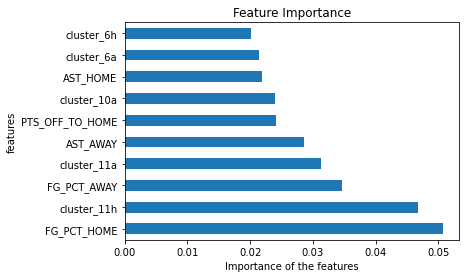

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.717388  0.785098   0.29884  11.124265


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.659152  0.745854  0.133189  12.491686




In [12]:
xgb_tuned = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=9,
             monotone_constraints='()', n_estimators=700, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9, tree_method='exact',
             validate_parameters=1, verbosity=None)
xgb_tuned.fit(X_train_standardized, y_train)

y_pred_xgb_train_tuned = xgb_tuned.predict(X_train_standardized)
y_pred_xgb_test_tuned = xgb_tuned.predict(X_test_standardized)

feat_importances_tuned = pd.Series(xgb_tuned.feature_importances_, index=X_train.columns)
feat_importances_tuned.nlargest(10).plot(kind='barh')

plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_xgb_train_tuned, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_xgb_test_tuned, y_test))
print('\n')


## PCA
Check whether PCA improve the model performance    
Since PCA did not improve the model performance, training with PCA is not persued further

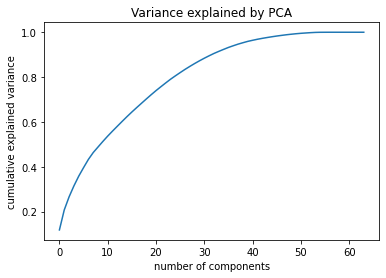

In [13]:
pca = PCA().fit(X_train_standardized)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Variance explained by PCA');

In [14]:
pca = PCA(n_components=30)
game_without_outcome_pca_train = pca.fit_transform(X_train_standardized)
game_without_outcome_pca_test = pca.fit_transform(X_test_standardized)

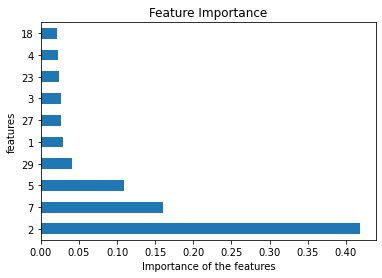

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.617448  0.727739  0.062153  12.865568


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.567779  0.699037 -0.081725  13.954601




In [20]:
regressor_tuned_pca = DecisionTreeRegressor(max_depth=10, max_features='auto', max_leaf_nodes=80,
                                        min_samples_leaf=20, min_weight_fraction_leaf=0.01,
                                        splitter='random', criterion='mse') 
regressor_tuned_pca.fit(game_without_outcome_pca_train, y_train)

y_pred_train_tuned_pca = regressor_tuned_pca.predict(game_without_outcome_pca_train)
y_pred_test_tuned_pca = regressor_tuned_pca.predict(game_without_outcome_pca_test)

feat_importances_tuned_pca = pd.Series(regressor_tuned_pca.feature_importances_)
feat_importances_tuned_pca.nlargest(10).plot(kind='barh')
plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_train_tuned_pca, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_test_tuned_pca, y_test))
print('\n')

In [23]:
reg_decision_model_pca=DecisionTreeRegressor()

tuning_model_decision_tree_pca=GridSearchCV(reg_decision_model_pca,
                                        param_grid=parameters_decision_tree,
                                        scoring='neg_mean_squared_error',
                                        cv=3,
                                        verbose=3)

In [24]:
tuned_model_pca = tuning_model_decision_tree_pca.fit(game_without_outcome_pca_train,y_train)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-166.234, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-169.281, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-172.502, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-166.644, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.839, total= 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-169.437, total=   0.0s
[CV]

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-169.281, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-172.502, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-165.475, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-172.171, total= 

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-168.216, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-175.867, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-173.617, total=   0.0s
[CV] max_d

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-165.244, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.066, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.646, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] ma

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-166.234, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-169.281, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-172.502, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-166.197, total=   0.0s
[CV] max_de

[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-169.847, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-178.076, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-173.619, total=   0.0s
[CV

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-175.523, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-175.259, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.889, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.105, total=   0.0s


[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-170.365, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-177.804, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-176.210, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-171.961, total=   0.

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-172.959, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-170.657, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-176.160, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-175.437, total=   0.0s
[CV

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-173.860, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-178.524, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-177.239, total=   0.0s
[CV

[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-180.001, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-176.072, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-169.239, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-177.533, total=   0.0s
[CV] m

[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-177.337, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-169.877, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-178.316, total=   0.0s
[CV] max_depth=5, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=log2,

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-180.185, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-176.594, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-169.251, total=   0

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-177.307, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-169.098, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.912, total=   0.0s
[CV] max_dep

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-179.236, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-177.044, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-166.347, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-178.776, total=   0.0s
[CV] max_dep

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-176.145, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-167.324, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-178.204, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-176.280, total=   0.0s
[CV] max_depth=5, m

[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-165.755, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.813, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-171.280, total=   0.0s
[CV] max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.791, total=   0.0s
[CV]

[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-166.234, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-169.281, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-172.502, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-164.844, total=   0.

[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-170.552, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-173.822, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-172.218, total=   0

[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-169.678, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-178.226, total=   0.0s
[CV] max_depth

[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-169.281, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-172.502, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-166.808, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-172.211, total=   0.0s
[CV] ma

[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-166.234, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-169.281, total=   0.2s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-172.502, total=   0.2s
[CV] max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-167.538, total=   0.0s
[CV] max_de

[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-173.283, total=   0.0s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=5, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_dep

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-171.330, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.381, total=   0.3s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.2s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-165.365, tota

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-170.823, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-178.514, total= 

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-170.607, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-173.785, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-164.804, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.216, total=   0.0s


[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-171.330, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.381, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-166.949, total=   0.0s
[CV]

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-170.929, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-171.334, total=   0.0s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-175.217, total=   0.0s
[CV

[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=auto, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-166.247, total=   0.0s
[CV]

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-173.448, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.834, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-180.182, 

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-173.450, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-176.114, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-180.192, total= 

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-178.521, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-172.713, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-172.014, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-179.385, total=   0.0s
[CV] ma

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-175.037, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-177.283, total=   0.0s
[CV

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-169.131, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-177.460, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-169.185, total=   0

[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-169.080, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-179.390, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-175.982, total=   0.0s
[CV] max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-171.383, total= 

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-172.040, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.712, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-176.828, total=   0.1s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-171.833, tota

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-175.489, total=   0.1s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.182, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-176.323, total=   0.0s
[CV

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-171.845, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-175.845, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-167.107, total=   0.0s
[CV

[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-179.143, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-176.616, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-170.299, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-176.410, total=   0.0s


[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-177.963, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-174.458, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-171.730, total=   0.0s
[CV] max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s


[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-171.330, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.381, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-166.231, tota

[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-169.878, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-177.317, total= 

[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-170.607, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-173.785, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-164.909, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-170.108, total=   0.0s


[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-168.959, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-178.015, total=   0.0s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-175.561, total=   0.0s
[CV

[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=10, max_features=None, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=10, max_features=None, max_l

[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-171.330, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.381, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.2s
[CV] max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=10, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-168.189, total=   0.

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-170.577, total=   0.

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-174.527, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-168.231, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-169.767, 

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-167.717, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-170.607, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-173.785, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-165.428, total=   0.0s
[CV]

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-170.814, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-177.116, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-174.192, total=   0.0s
[CV

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-171.327, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-170.737, total=   0.0s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] m

[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-171.293, total=   0.1s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.527, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.2s
[CV] max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=auto, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-166.166, total=   0.

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-175.968, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-177.121, tot

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-170.916, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-178.326, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-172.696, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-171.921, total=   0.

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-176.283, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-168.018, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-176.095, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-175.972, total=   0.0s
[CV] max_dep

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.322, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-175.110, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-169.615, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-180.200, total=   0.0s


[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-173.044, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-171.730, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-173.851, total=   0

[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-178.698, total=   0.1s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-170.615, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-178.582, total=   0.0s
[CV] max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=log2, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-172.593, tot

[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-172.070, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-170.827, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.455, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.071, total= 

[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-171.197, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-175.766, total=   0.1s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-172.328, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-172.022, total=   0.0s
[CV]

[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-173.344, total=   0.1s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.084, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.326, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-169.631, total=   0.0s
[CV]

[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-171.629, total=   0.1s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-176.287, total=   0.1s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-175.404, total=   0.1s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=sqrt

[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-171.223, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-171.450, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-174.320, total=   0.0s
[CV] max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-177.424, total=   0

[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-165.874, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-172.419, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-173.1

[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-169.734, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-178.419, total= 

[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-173.785, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-168.406, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.118, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-170.702, total=   0

[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-171.293, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.527, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-166.034, total=   0.0s
[CV]

[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-166.643, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-177.726, total=   0.0s
[CV] ma

[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-174.527, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.2s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-167.406, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-170.809, total= 

[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-168.649, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-173.108, total=   0.0s
[CV] max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=20, max_features=None, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.1, splitter=random, score=-173.017, total=   0

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-174.527, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-166.611, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-172.990, 

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=-167.363, total=   0.0s
[CV] max_de

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-167.717, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-170.607, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-173.785, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-164.686, total=   0.0s
[CV]

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-167.928, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-178.205, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-174.379, total=   0.0s
[CV

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-166.723, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-170.151, total=   0.0s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-170.733, tot

[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-171.293, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-174.527, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.1s
[CV] max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=auto, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-165.908, total=   0.

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-176.779, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-171.055, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-179.717, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=None, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-176.5

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-168.646, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-172.979, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-173.700, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=40, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-168.825, total=   0.0s
[CV] max_de

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-173.638, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-178.912, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.463, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-178.792, total=   0.0s


[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-175.178, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-175.705, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-171.451, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=80, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=random, score=-180.281, total=   0.0s
[CV] ma

[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=best, score=-178.001, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-171.868, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-178.364, total=   0.0s
[CV] max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=log2, max_leaf_nodes=120, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-177.131, tot

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-179.089, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.011, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-169.782, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-176.503, 

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-173.683, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-175.221, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-170.633, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-180.281, 

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-175.050, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=best, score=-172.121, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-169.732, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-176.948, total=   0.0s


[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.01, splitter=random, score=-177.446, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-165.462, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-175.897, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-172.701, total=   0.0s
[CV] max_dep

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-175.391, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-171.387, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-176.863, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-175.745, tot

[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-172.603, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-172.388, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-171.961, total=   0.0s
[CV] max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=sqrt, max_leaf_nodes=120, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-175.255, total= 

[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-171.217, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=None, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-176.636, total= 

[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-170.607, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-173.785, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-167.315, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-168.566, total=   0.0s


[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-167.717, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-170.607, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=best, score=-173.785, total=   0.2s
[CV] max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=40, min_samples_leaf=40, min_weight_fraction_leaf=0.01, splitter=random, score=-164.094, total=   0.0s
[CV]

[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=80, min_samples_leaf=20, min_weight_fraction_leaf=0.1, splitter=random, score=-169.590, total=   0.0s
[CV] max_de

[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-171.293, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-174.527, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=best, score=-176.538, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=10, min_weight_fraction_leaf=0.01, splitter=random, score=-167.096, total=   0.

[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.01, splitter=random, score=-172.132, total=   0.0s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-166.104, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-169.929, total=   0.1s
[CV] max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  max_depth=30, max_features=None, max_leaf_nodes=120, min_samples_leaf=30, min_weight_fraction_leaf=0.1, splitter=best, score=-170.142, total=   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  2.1min finished


In [25]:
best_grid = tuned_model_pca.best_estimator_
best_grid

DecisionTreeRegressor(max_depth=20, min_samples_leaf=40,
                      min_weight_fraction_leaf=0.01, splitter='random')

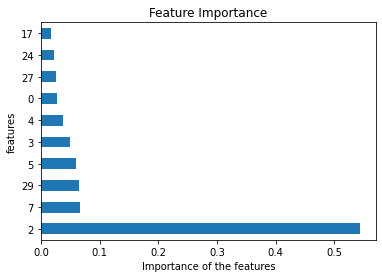

Evaluation metrics on training data: 
   Accuracy  F1 Score  R Square       RMSE
0  0.619853  0.721742  0.068454  12.822276


Evaluation metrics on testing data: 
   Accuracy  F1 Score  R Square       RMSE
0   0.54193  0.671835 -0.119985  14.199237




In [27]:
regressor_tuned_pca = DecisionTreeRegressor(max_depth=20, min_samples_leaf=40,
                                            min_weight_fraction_leaf=0.01, splitter='random', 
                                            criterion='mse') 
regressor_tuned_pca.fit(game_without_outcome_pca_train, y_train)

y_pred_train_tuned_pca = regressor_tuned_pca.predict(game_without_outcome_pca_train)
y_pred_test_tuned_pca = regressor_tuned_pca.predict(game_without_outcome_pca_test)

feat_importances_tuned_pca = pd.Series(regressor_tuned_pca.feature_importances_)
feat_importances_tuned_pca.nlargest(10).plot(kind='barh')
plt.xlabel('Importance of the features')
plt.ylabel('features')
plt.title('Feature Importance')
plt.show()

print ("Evaluation metrics on training data: ")
print(model_evaluation(y_pred_train_tuned_pca, y_train))
print('\n')
print ("Evaluation metrics on testing data: ")
print(model_evaluation(y_pred_test_tuned_pca, y_test))
print('\n')